In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import deeplake

In [3]:
ds_train = deeplake.load("hub://activeloop/lsp-train")
ds_test = deeplake.load("hub://activeloop/lsp-test")

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



|

hub://activeloop/lsp-train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test



/

hub://activeloop/lsp-test loaded successfully.



In [4]:
dataloader_train = ds_train.tensorflow()
dataloader_test = ds_test.tensorflow()

In [5]:
def normalize_keypoints(keypoints,bounding_box):
    keypoints[:,0] = (keypoints[:,0] - bounding_box[0])/bounding_box[2]
    keypoints[:,1] = (keypoints[:,1] - bounding_box[1])/bounding_box[3]
    return keypoints

In [6]:
def unnormalize_keypoints(keypoints,bounding_box):
    keypoints[:,0] = (keypoints[:,0]*bounding_box[2]) + bounding_box[0]
    keypoints[:,1] = (keypoints[:,1]*bounding_box[3]) + bounding_box[1]
    keypoints[:,0] = np.clip(keypoints[:,0],0,bounding_box[2])
    keypoints[:,1] = np.clip(keypoints[:,1],0,bounding_box[3])
    return keypoints.astype(np.int32)

In [8]:
def visualize_keypoints(image,keypoints,image_visualized):
    height,width = image_visualized.shape[:2]
    try:
        image = cv2.resize(image.numpy(),(width,height))
    except:
        image = cv2.resize(image,(width,height))
    fig , ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image)
    ax.scatter(keypoints[:,0],keypoints[:,1])
    for i in range(keypoints.shape[0]):
        ax.annotate(str(i), (keypoints[i,0],keypoints[i,1]),fontsize=10)
    for i in range(0,5):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(6,11):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(12,13):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    plt.show()

In [9]:
batch_iter = iter(dataloader_train)
batch = next(batch_iter)

In [10]:
batch = next(batch_iter)
image = batch["images"]
keypoints = batch["keypoints"]
image_visualized = batch["images_visualized"]


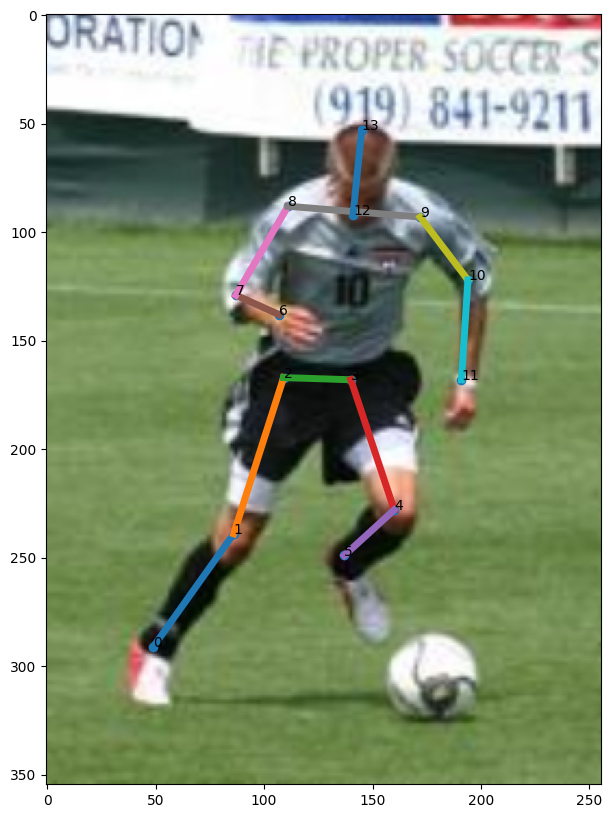

In [11]:
visualize_keypoints(image,keypoints,image_visualized)

In [12]:
images = []
keypoints_array = []

for batch in dataloader_train:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

for batch in dataloader_test:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

images = np.array(images)
keypoints_array = np.array(keypoints_array,dtype=np.float32)

In [13]:
def get_model(output = 14*2):
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(96,(11,11),strides=(4,4),activation="relu",input_shape=(220,220,3)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2)),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(output,activation="linear")])
    return model


In [14]:
model = get_model()

In [15]:
def loss_fn(y_true,y_pred):
    y_pred = tf.reshape(y_pred,(-1,14,2))
    return tf.reduce_sum(tf.square(y_true-y_pred))

In [16]:
sample = images[0]
sample = cv2.resize(sample,(220,220)).astype(np.float32)/255.0
sample = np.expand_dims(sample,axis=0)
sample = tf.convert_to_tensor(sample,dtype=tf.float32)
pred = model(sample)

In [17]:
loss_fn(keypoints_array[0],pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1281447>

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss_fn)

In [19]:
model.fit(images,keypoints_array,epochs=10,batch_size=2,validation_split=0.1,shuffle=True,verbose=1)

Epoch 1/10
900/900 [==============================] - 383s 422ms/step - loss: 18.6997 - val_loss: 1.7266
Epoch 2/10
900/900 [==============================] - 330s 367ms/step - loss: 2.2511 - val_loss: 1.7167
Epoch 3/10
900/900 [==============================] - 311s 346ms/step - loss: 1.5375 - val_loss: 1.5739
Epoch 4/10
900/900 [==============================] - 314s 349ms/step - loss: 1.3755 - val_loss: 1.3348
Epoch 5/10
900/900 [==============================] - 475s 529ms/step - loss: 1.3040 - val_loss: 1.2376
Epoch 6/10
900/900 [==============================] - 314s 349ms/step - loss: 1.2458 - val_loss: 1.2514
Epoch 7/10
900/900 [==============================] - 319s 355ms/step - loss: 1.2244 - val_loss: 1.2365
Epoch 8/10
900/900 [==============================] - 324s 361ms/step - loss: 1.1827 - val_loss: 1.1755
Epoch 9/10
900/900 [==============================] - 314s 349ms/step - loss: 1.1590 - val_loss: 1.1818
Epoch 10/10
900/900 [==============================] - 312s 347

In [20]:
 model.save("deeppose.h5")

In [21]:
model = tf.keras.models.load_model("deeppose.h5",custom_objects={"loss_fn":loss_fn})


In [22]:
def get_preds(model,image):
    image= cv2.resize(image,(220,220))
    image = np.expand_dims(image,axis=0)
    image = tf.convert_to_tensor(image,dtype=tf.float32)
    pred = model(image)
    pred = tf.reshape(pred,(14,2))
    return pred

In [23]:
test_iter = iter(dataloader_test)

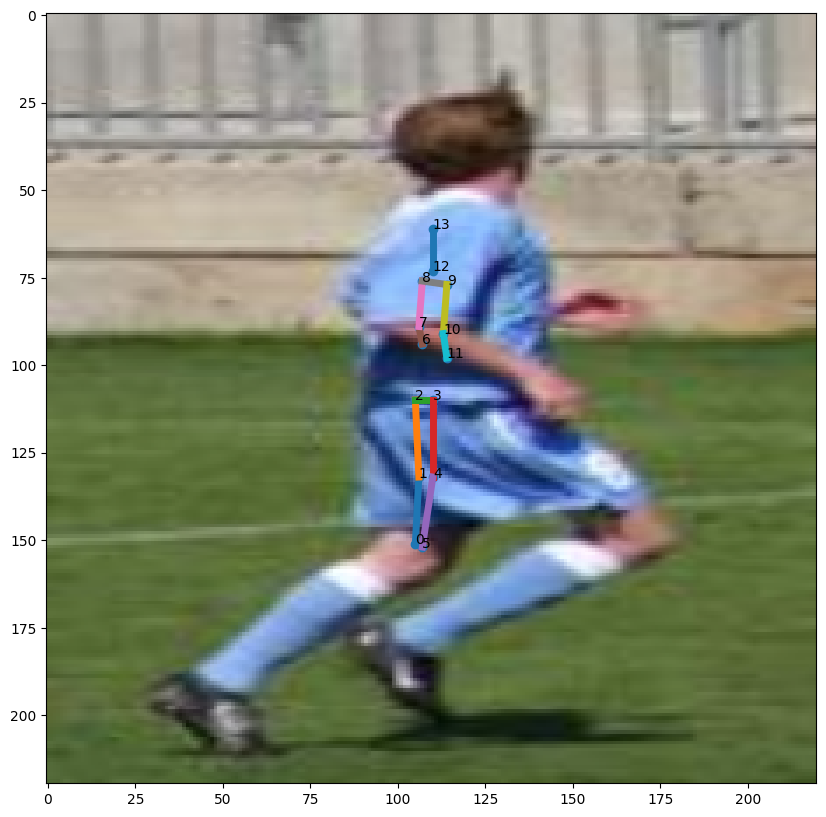

In [24]:
img = next(test_iter)["images"].numpy()
img = cv2.resize(img,(220,220))
image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
pred = get_preds(model,image).numpy()
keypoints = unnormalize_keypoints(pred,(110,110,220,220))
visualize_keypoints(img,keypoints,img)